In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 830.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData
from sklearn.preprocessing import LabelEncoder

# Carichiamo il dataset
file_path = '/content/reduced_dataset_100k.csv'
dataset = pd.read_csv(file_path)

# 1. Selezioniamo le colonne rilevanti
paziente_diagnosi_malattia = dataset[['CODICE_FISCALE_ASSISTITO', 'ICD9_CM', 'DATA_PRESCRIZIONE', 'ANNO_NASCITA', 'SESSO', 'DISEASE_LABEL']]

# Convertiamo le date in formato datetime
paziente_diagnosi_malattia['DATA_PRESCRIZIONE'] = pd.to_datetime(paziente_diagnosi_malattia['DATA_PRESCRIZIONE'])

# 2. Codifica degli attributi
# Codifica del sesso con LabelEncoder
le_sesso = LabelEncoder()
paziente_diagnosi_malattia['SESSO_CODE'] = le_sesso.fit_transform(paziente_diagnosi_malattia['SESSO'])

# Codifica dei codici ICD9 e delle descrizioni delle malattie
le_icd9 = LabelEncoder()
paziente_diagnosi_malattia['ICD9_CM_CODE'] = le_icd9.fit_transform(paziente_diagnosi_malattia['ICD9_CM'])

le_descrizione = LabelEncoder()
paziente_diagnosi_malattia['ETICHETTA_CODE'] = le_descrizione.fit_transform(paziente_diagnosi_malattia['DISEASE_LABEL'])

# 3. Creiamo il grafo eterogeneo
data = HeteroData()

# Mappature per i nodi pazienti
paziente_id_counter = 0

# Liste per raccogliere nodi e archi
paziente_x = []
malattia_x = []
edge_index_paziente_malattia = []
edge_attr_paziente_malattia = []
edge_index_paziente_temporale = []
edge_attr_paziente_temporale = []

# 4. Creiamo i sotto-grafi per paziente
for paziente in paziente_diagnosi_malattia['CODICE_FISCALE_ASSISTITO'].unique():
    paziente_data = paziente_diagnosi_malattia[paziente_diagnosi_malattia['CODICE_FISCALE_ASSISTITO'] == paziente]
    paziente_data = paziente_data.sort_values(by='DATA_PRESCRIZIONE')

    malattie_contratte = {}  # Dizionario per tracciare le malattie e i pesi degli archi
    nodi_paziente_creati = []
    data_prescrizione_precedente = None

    for idx, row in paziente_data.iterrows():
        malattia_idx = row['ICD9_CM_CODE']
        data_prescrizione = row['DATA_PRESCRIZIONE']

        # Calcolo dell'età alla data della prescrizione
        età = data_prescrizione.year - row['ANNO_NASCITA']

        # Creazione nodo paziente con età e sesso codificato
        paziente_feature = torch.tensor([età, row['SESSO_CODE']], dtype=torch.float)
        paziente_x.append(paziente_feature)

        paziente_idx = paziente_id_counter
        paziente_id_counter += 1

        # Aggiunta nodo malattia solo se nuova malattia
        if malattia_idx not in malattie_contratte:
            malattia_feature = torch.tensor([row['ICD9_CM_CODE'], row['ETICHETTA_CODE']], dtype=torch.float)
            malattia_x.append(malattia_feature)
            malattie_contratte[malattia_idx] = 1  # Prima occorrenza
        else:
            # Incremento del peso dell'arco se la malattia è ricomparsa
            malattie_contratte[malattia_idx] += 1

        # Aggiungere un arco per la nuova malattia (o incrementare il peso)
        edge_index_paziente_malattia.append([paziente_idx, malattia_idx])
        edge_attr_paziente_malattia.append(malattie_contratte[malattia_idx])

        # Aggiungere archi per le malattie contratte in precedenza
        for malattia_prec_idx in malattie_contratte:
            if malattia_prec_idx != malattia_idx:
                edge_index_paziente_malattia.append([paziente_idx, malattia_prec_idx])
                edge_attr_paziente_malattia.append(malattie_contratte[malattia_prec_idx])

        # Collegamento al nodo paziente precedente
        if nodi_paziente_creati:
            edge_index_paziente_temporale.append([nodi_paziente_creati[-1], paziente_idx])
            if data_prescrizione_precedente is not None:
                #differenza_temporale = (data_prescrizione - data_prescrizione_precedente).days
                timestamp_prescrizione = data_prescrizione.timestamp()
                edge_attr_paziente_temporale.append(timestamp_prescrizione)

        # Aggiorna nodi paziente creati e la data della prescrizione
        nodi_paziente_creati.append(paziente_idx)
        data_prescrizione_precedente = data_prescrizione

# 5. Convertiamo le liste in tensori finali
data['paziente'].x = torch.stack(paziente_x)
data['malattia'].x = torch.stack(malattia_x)
data['paziente', 'diagnosi', 'malattia'].edge_index = torch.tensor(edge_index_paziente_malattia, dtype=torch.long).t().contiguous()
data['paziente', 'diagnosi', 'malattia'].edge_attr = torch.tensor(edge_attr_paziente_malattia, dtype=torch.float)
data['paziente', 'next', 'paziente'].edge_index = torch.tensor(edge_index_paziente_temporale, dtype=torch.long).t().contiguous()
data['paziente', 'next', 'paziente'].edge_attr = torch.tensor(edge_attr_paziente_temporale, dtype=torch.float)

# Verifiche finali
print(f"Numero di nodi pazienti: {data['paziente'].x.shape[0]}, Feature shape: {data['paziente'].x.shape}")
print(f"Numero di nodi malattie: {data['malattia'].x.shape[0]}, Feature shape: {data['malattia'].x.shape}")


<ipython-input-2-b1037633a2d8>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paziente_diagnosi_malattia['DATA_PRESCRIZIONE'] = pd.to_datetime(paziente_diagnosi_malattia['DATA_PRESCRIZIONE'])
<ipython-input-2-b1037633a2d8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paziente_diagnosi_malattia['SESSO_CODE'] = le_sesso.fit_transform(paziente_diagnosi_malattia['SESSO'])
<ipython-input-2-b1037633a2d8>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Numero di nodi pazienti: 99502, Feature shape: torch.Size([99502, 2])
Numero di nodi malattie: 7907, Feature shape: torch.Size([7907, 2])


In [ ]:
from torch_geometric.utils import negative_sampling

# 7. Generazione degli archi negativi e assegnazione delle etichette

# Otteniamo gli archi positivi (paziente → malattia)
positive_edge_index = data['paziente', 'diagnosi', 'malattia'].edge_index

# Creiamo le etichette per gli archi positivi (1 per ogni arco positivo)
positive_edge_label = torch.ones(positive_edge_index.size(1))

# Generiamo archi negativi per la relazione paziente-malattia
neg_edge_index = negative_sampling(positive_edge_index, num_nodes=(data['paziente'].x.size(0), data['malattia'].x.size(0)), num_neg_samples=int(positive_edge_index.size(1) * 0.5))

# Creiamo le etichette per gli archi negativi (0 per ogni arco negativo)
negative_edge_label = torch.zeros(neg_edge_index.size(1))

# Concatenare gli edge_index positivi e negativi
final_edge_index = torch.cat([positive_edge_index, neg_edge_index], dim=1)

# Concatenare le etichette positive e negative
final_edge_label = torch.cat([positive_edge_label, negative_edge_label])

# Shuffle per mescolare i dati
perm = torch.randperm(final_edge_index.size(1))
final_edge_index = final_edge_index[:, perm]
final_edge_label = final_edge_label[perm]

In [ ]:
# 8. Train-test split
def train_test_split_edges(data, test_ratio=0.15, val_ratio=0.15):
    pazienti = torch.unique(final_edge_index[0])
    perm_pazienti = torch.randperm(pazienti.size(0))
    pazienti = pazienti[perm_pazienti]
    num_test = int(pazienti.size(0) * test_ratio)
    num_val = int(pazienti.size(0) * val_ratio)
    test_pazienti = pazienti[:num_test]
    val_pazienti = pazienti[num_test:num_test + num_val]
    train_pazienti = pazienti[num_test + num_val:]

    def filter_edges_by_pazienti(edge_index, edge_label, pazienti):
        mask = torch.isin(edge_index[0], pazienti)
        return edge_index[:, mask], edge_label[mask]

    train_edges, train_labels = filter_edges_by_pazienti(final_edge_index, final_edge_label, train_pazienti)
    val_edges, val_labels = filter_edges_by_pazienti(final_edge_index, final_edge_label, val_pazienti)
    test_edges, test_labels = filter_edges_by_pazienti(final_edge_index, final_edge_label, test_pazienti)

    return (train_edges, train_labels, val_edges, val_labels, test_edges, test_labels)

(train_edges, train_labels, val_edges, val_labels, test_edges, test_labels) = train_test_split_edges(data)


In [ ]:
import torch
from torch_geometric.nn import HeteroConv, GATConv, Linear
import torch.nn.functional as F

class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout=0.5):
        super(HeteroGNN, self).__init__()

        self.dropout = dropout  # Probabilità di dropout

        # Primo livello di convoluzione eterogenea con GATConv
        self.conv1 = HeteroConv({
            ('paziente', 'diagnosi', 'malattia'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
            ('paziente', 'next', 'paziente'): GATConv((-1, -1), hidden_channels, add_self_loops=False)
        }, aggr='mean')

        # Secondo livello di convoluzione eterogenea con GATConv
        self.conv2 = HeteroConv({
            ('paziente', 'diagnosi', 'malattia'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
            ('paziente', 'next', 'paziente'): GATConv((-1, -1), hidden_channels, add_self_loops=False)
        }, aggr='mean')

        self.conv3 = HeteroConv({
            ('paziente', 'diagnosi', 'malattia'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
            ('paziente', 'next', 'paziente'): GATConv((-1, -1), hidden_channels, add_self_loops=False)
        }, aggr='mean')

        # Layer finale per la predizione dei link
        self.decoder = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        # Primo livello di convoluzione con Dropout e pesi degli archi
        x_dict = self.conv1(x_dict, edge_index_dict, edge_attr_dict=edge_attr_dict)
        x_dict = {key: F.dropout(F.relu(x), p=self.dropout, training=self.training) for key, x in x_dict.items()}

        # Secondo livello di convoluzione con Dropout e pesi degli archi
        x_dict = self.conv2(x_dict, edge_index_dict, edge_attr_dict=edge_attr_dict)
        x_dict = {key: F.dropout(F.relu(x), p=self.dropout, training=self.training) for key, x in x_dict.items()}

        # Terzo livello di convoluzione con Dropout e pesi degli archi
        x_dict = self.conv3(x_dict, edge_index_dict, edge_attr_dict=edge_attr_dict)
        x_dict = {key: F.dropout(F.relu(x), p=self.dropout, training=self.training) for key, x in x_dict.items()}

        return x_dict


    def decode(self, z_dict, edge_label_index):
        src, dst = edge_label_index
        paziente_emb = z_dict['paziente'][src]
        malattia_emb = z_dict['malattia'][dst]
        return torch.sigmoid((paziente_emb * malattia_emb).sum(dim=-1))



Epoch 1, Train Loss: 0.4470, Train Accuracy: 0.9385, Val Accuracy: 0.6670
Epoch 2, Train Loss: 0.4523, Train Accuracy: 0.6609, Val Accuracy: 0.6670
Epoch 3, Train Loss: 0.4478, Train Accuracy: 0.6626, Val Accuracy: 0.6682
Epoch 4, Train Loss: 0.4469, Train Accuracy: 0.8492, Val Accuracy: 0.6683
Epoch 5, Train Loss: 0.4469, Train Accuracy: 0.8550, Val Accuracy: 0.9494
Epoch 6, Train Loss: 0.4467, Train Accuracy: 0.9194, Val Accuracy: 0.6683
Epoch 7, Train Loss: 0.4468, Train Accuracy: 0.8509, Val Accuracy: 0.9494
Epoch 8, Train Loss: 0.4470, Train Accuracy: 0.9038, Val Accuracy: 0.9494
Epoch 9, Train Loss: 0.4468, Train Accuracy: 0.9048, Val Accuracy: 0.6683
Epoch 10, Train Loss: 0.4468, Train Accuracy: 0.8888, Val Accuracy: 0.6683
Epoch 11, Train Loss: 0.4468, Train Accuracy: 0.8940, Val Accuracy: 0.9494
Epoch 12, Train Loss: 0.4466, Train Accuracy: 0.9305, Val Accuracy: 0.9494
Epoch 13, Train Loss: 0.4466, Train Accuracy: 0.9439, Val Accuracy: 0.6683
Epoch 14, Train Loss: 0.4466, Trai

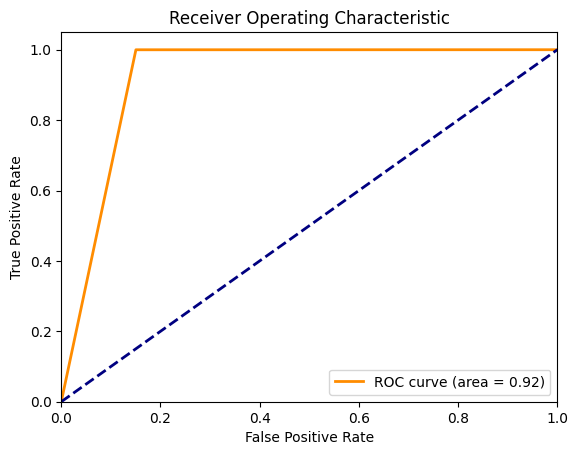

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = HeteroGNN(hidden_channels=64, out_channels=1)

# Ponderazione per bilanciare tra classi positive e negative
pos_weight = len(negative_edge_label) / len(positive_edge_label)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))

def train(model, data, train_edges, train_labels, edge_attr_dict, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    z_dict = model(data.x_dict, data.edge_index_dict, edge_attr_dict=edge_attr_dict)
    pred = model.decode(z_dict, train_edges)

    # Calcolo della loss
    loss = loss_fn(pred, train_labels)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Calcolo dell'accuracy su training set
    pred_binary = (pred > 0.5).float()
    train_accuracy = (pred_binary == train_labels).float().mean().item()

    return loss.item(), train_accuracy

def evaluate(model, data, val_edges, val_labels, edge_attr_dict, is_test=False):
    model.eval()
    with torch.no_grad():
        # Forward pass per il validation set o il test set
        z_dict = model(data.x_dict, data.edge_index_dict, edge_attr_dict=edge_attr_dict)
        val_pred = model.decode(z_dict, val_edges)

    # Calcolo delle predizioni binarie
    val_pred_binary = (val_pred > 0.5).float()

    # Calcolo dell'accuracy
    val_accuracy = (val_pred_binary == val_labels).float().mean().item()

    if is_test:
        # Calcolo delle metriche
        val_auc = roc_auc_score(val_labels.cpu().numpy(), val_pred.cpu().numpy())
        precision = precision_score(val_labels.cpu().numpy(), val_pred_binary.cpu().numpy())
        f1 = f1_score(val_labels.cpu().numpy(), val_pred_binary.cpu().numpy())
        accuracy = accuracy_score(val_labels.cpu().numpy(), val_pred_binary.cpu().numpy())

        # Per il ROC curve plot
        fpr, tpr, _ = roc_curve(val_labels.cpu().numpy(), val_pred.cpu().numpy())
        return val_accuracy, val_auc, precision, f1, fpr, tpr
    else:
        return val_accuracy

# Addestramento e valutazione
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    edge_attr_dict = {
        ('paziente', 'diagnosi', 'malattia'): data['paziente', 'diagnosi', 'malattia'].edge_attr,
        ('paziente', 'next', 'paziente'): data['paziente', 'next', 'paziente'].edge_attr
    }

    # Fase di training
    train_loss, train_accuracy = train(model, data, train_edges, train_labels, edge_attr_dict, optimizer, loss_fn)

    # Valutazione sul validation set
    val_accuracy = evaluate(model, data, val_edges, val_labels, edge_attr_dict)

    # Stampa di train loss, train accuracy e val accuracy
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Valutazione finale sul test set dopo l'ultima epoca
test_accuracy, test_auc, precision, f1, fpr, tpr = evaluate(model, data, test_edges, test_labels, edge_attr_dict, is_test=True)

# Stampa delle metriche finali
print(f"Test Accuracy: {test_accuracy:.4f}, ROC AUC: {test_auc:.4f}")
print(f"Precision: {precision:.4f}, F1-Score: {f1:.4f}")

# Plot della curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
